# Demonstration of the iterative update with reference

AGIS (Astrometric General Iterative Solution) is a code used to inference the astrometric parameters in the Gaia mission. AGIS optimizes the parameters of an observation model by minimizing the least square of residuals. The size of the problem makes it difficult to obtain the solution. AGIS categorizes the parameters into several groups and optimizes each category iteratively. This approach helps us to handle an enormously large optimization problem.

This notebook demonstrates an optimization procedure along with the AGIS approach. Instead of a realistic astrometric problem, we set up a one-dimensional mock observation problem.

We use `jax` to make the best use of the _auto-differentiation_ technique.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
jax.config.update('jax_enable_x64', True)
np.random.seed(42)

## Model

The observation model is defined here.

### Longitude

This function virtually defines the location of the Earth. $L(t)$ is the longitude of the Earth and $t$ is the observation epoch. $T$ is the revolution period of the Earth.

$$
  L(t) = 2\pi \frac{t}{T}
$$

In [2]:
def longitude(t, T=3.0):
  ''' Longitude of the Earth

  Arguments:
      t: epoch of the observation

  Returns:
    The longitude of the Earth in radian.
  '''
  return 2 * jnp.pi * (t / T)

### Epoch Position

Each star has astrometric parameters $(x_{0,i}, \mu_{i}, \varpi_{i})$, which correspond to the position of the catalog epoch, the proper motion, and the parallax, respectively. The catalog epoch is set $t=0$. The position of a star at the observation epoch, $\alpha_{i}(t)$, is given by the following expression.

$$
  \alpha_{i}(t) = \alpha_{0,i} + \mu_{i} t + \varpi_{i} \sin L(t)
$$

In [3]:
def epoch_position(s, t):
  ''' Celestial position of a source

  Arguments:
      s: source parameters
        s[0]: position
        s[1]: proper motion
        s[2]: parallax

  Returns:
    The celestial position of the source at the observation epoch.
  '''
  return s[0] + s[1] * t + s[2] * jnp.sin(longitude(t))

### Position on the ideal plane

We observe stars with a telescope. The stars are projected onto a focal plane via the _tangential_ projection. $p(t)$ is the direction of the telescope pointing, and $s(t)$ is the plate scale. The position on the ideal focal plane, $\eta_{i}(t), is defined by the following expression.

$$
  \eta_{i}(t) = \tan\Big(s(t)\big(\alpha_{i}(t) - p(t)\big)\Big)
$$

In [4]:
def position_ideal_plane(s, e, t):
  ''' Position on the ideal focal plane

  Arguments:
    s: source parameters
    e: exposure parameters
        e[0]: telescope pointing
        e[1]: telescope scaling

  Returns:
    The position on the ideal focal plane at the observation epoch.
  '''
  alpha = epoch_position(s, t)
  eta = alpha - e[0]
  return jnp.tan(e[1] * eta)

### Position on the focal plane

We consider the telescope optics is not ideal. The detector is not located at the center of the focal plane, and it can be distorted. The deviation from the tangential projection is described by a polynomial function. $c_0$, $c_1$, and $c_2$ are the coefficients of the distortion. The measured position without error, $\zeta_{i}(t)$, is given by the following expression.

$$
  \zeta_{i}(t) = \eta_{i}(t) + c_0 + c_1 \eta_{i}(t) + \frac{c_2}{2}\eta_{i}(t)^2
$$

In [5]:
def position_focal_plane(s, e, c, t):
  ''' Position on the actual focal plane

  Arguments:
    s: source parameters
    e: exposure parameters
    c: calibration parameters
        c[0]: offset
        c[1]: linear slope
        c[2]: quadratic

  Returns:
    The position on the focal plane with distortion.
  '''
  eta = position_ideal_plane(s, e, t)
  return eta + c[0] + c[1] * eta + 0.5 * c[2] * eta**2

zeta = jax.jit(position_focal_plane)

## Generate simulation

We set up the simulation. We prepare 200 artificial sources. The astrometric parameters are randomly sampled. The observations are scheduled from $t=0$ to $10$ with equal intervals. The number of observations is 1000. The telescope pointing directions are randomly sampled. We assume that the plate scale is not stable. Thus, we randomly sampled the plate scales at the observation epoch. Finally, we manually define the distortion parameters.

`src`, `exp`, and `cal` contain the ground truth of the parameters. `src` contains the source astrometric parameters with `source_id`. `exp` contains the exposure parameters with `exposure_id`. `cal` contains the distortion parameters.

In [6]:
pkey = jax.random.PRNGKey(42)

source_id = jnp.arange(200)
x0 = np.random.uniform(-1.0, 1.0, size=source_id.shape)
mu = np.random.normal(0, 0.05, size=source_id.shape)
plx = np.random.gamma(3, 0.05 / 3, size=source_id.shape)
mag = np.random.uniform(10, 15, size=source_id.shape)
flx = 1e4 * 10 ** (-0.4 * mag)

exposure_id = jnp.arange(1000)
ep = jnp.linspace(-5, 5, exposure_id.size)
pt = np.random.uniform(-2.0, 2.0, size=exposure_id.shape)
st = np.random.gamma(50.0, 0.15/50.0, size=exposure_id.shape)

c0 = -0.15
c1 = +0.10
c2 = +0.15

src = jnp.stack([source_id, x0, mu, plx]).T
exp = jnp.stack([exposure_id, ep, pt, st]).T
cal = jnp.stack([c0, c1, c2]).T

The initial estimates of the parameters are prepared as follows:

In [7]:
shat = jnp.hstack([
  src[:, 0:1],
  src[:, 1:2] + np.random.normal(0.0, 0.05, size=src[:, 1:2].shape),
  src[:, 2:3] * 0,
  src[:, 3:4] * 0,
])
ehat = jnp.hstack([
  exp[:, 0:2],
  exp[:, 2:3] + np.random.normal(0.0, 0.01, size=exp[:, 2:3].shape),
  exp[:, 3:4] * 0 + 0.15,
])
chat = jnp.array(jnp.zeros(shape=cal.shape))

## Generate measurements

Measurements are generated using the function `zeta`. The measurements can be affected by noise. Here, we assume that the measurement error is given by a Gaussian distribution with the standard deviation of $\sigma_\text{obs}$.

$$
  \tilde\zeta_{i}(t) = \mathcal{N}(\zeta_{i}(t), \sigma_\text{obs})
$$

In [8]:
_iterate_src = jax.vmap(zeta, (0, None, None, None), 0)
_iterate_exp = jax.vmap(zeta, (None, 0, None, 0), 0)
_iterate_full = jax.vmap(_iterate_src, (None, 0, None, 0), 0)
exposure = lambda s, e, c, t: _iterate_full(s, e, c, t).ravel()


def estimate(src, exp, cal, noise=None):
  ''' Generate the focal plane position from the parameters

  Arguments:
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The estimated measurements for the given paramters.
    The measurements are disturbed if noise is not zero.
  '''
  obs = exposure(src[:, 1:], exp[:, 2:], cal, exp[:, 1])
  if noise is not None:
    sig = np.random.gamma(100.0, np.tile(noise, exp.shape[0]) / 100.0)
    obs = np.random.normal(obs, sig)
  else:
    sig = jnp.zeros(shape=obs.shape)
  sid = jnp.tile(src[:, 0], exp.shape[0])
  eid = jnp.repeat(exp[:, 0], src.shape[0])
  return jnp.stack([sid, eid, obs.copy(), sig.copy()]).T

We generated the mock measurements with the measurement error defined based on the source flux

In [9]:
sig = 0.01 / np.sqrt(flx)
obs = estimate(src, exp, cal, sig)

The reference catalog was defined as follows. About 10 % sources were randomly selected as the reference sources. We set tight priors for the reference sources.

In [10]:
ref_id  = np.random.binomial(1, 0.1, size=source_id.shape[0])
sig_x0  = np.random.gamma(1000, 0.0001 / 1000, size=source_id.shape)
sig_mu  = np.random.gamma(1000, 0.0001 / 1000, size=source_id.shape)
sig_plx = np.random.gamma(1000, 0.0001 / 1000, size=source_id.shape)

ref = jnp.stack([
  np.where(ref_id, np.random.normal(x0, sig_x0), np.random.normal(x0, 0.1)),
  np.where(ref_id, np.random.normal(mu, sig_mu), 0.0),
  np.where(ref_id, np.random.normal(plx, sig_plx), 0.0),
  np.where(ref_id, sig_x0, 1e18),
  np.where(ref_id, sig_mu, 1e18),
  np.where(ref_id, sig_plx, 1e18),
]).T

The following functions are defined to help update calculation.

In [11]:
def estimate_for_exposure(src, exp, cal):
  ''' Generate the focal plane position for a specific exposure

  Arguments:
      src: source parameters (iteration key)
      exp: exposure parameters of a specific exposure
      cal: calibration parameters

  Returns:
    The estimated measurements for the specific exposure.
  '''
  z = _iterate_src(src[:, 1:], exp[2:], cal, exp[1])
  return jnp.stack([src[:, 0], jnp.tile(exp[0], z.size), z]).T


def estimate_for_source(src, exp, cal):
  ''' Generate the focal plane position for a specific source

  Arguments:
      src: source parameters of a specific source
      exp: exposure parameters (iteration key)
      cal: calibration parameters

  Returns:
    The estimated measurements for the specific source.
  '''
  z = _iterate_exp(src[1:], exp[:, 2:], cal, exp[:, 1])
  return jnp.stack([jnp.tile(src[0], z.size), exp[:, 1], z]).T

We define a function to visualize the residuals of the parameters from the ground truth.

In [12]:
def visualize(sx, ex, cx):
  _iterate_trace = jax.vmap(
    jax.vmap(epoch_position, (0, None), 0), (None, 0), 0)

  def residual(z):
    return jnp.sqrt(jnp.mean((obs[:, 2] - z[:, 2])**2))

  def limit_range(p0, p1, index):
    m = min([min(p0[:, index]), min(p1[:, index])])
    M = max([max(p0[:, index]), max(p1[:, index])])
    return m, M

  def trace(src, exp):
    pos = _iterate_trace(src[:, 1:], exp[:, 1:2]).ravel()
    sid = jnp.tile(src[:, 0], exp.shape[0])
    eph = jnp.repeat(exp[:, 1], src.shape[0])
    return jnp.stack([sid, eph, pos]).T

  ycoo = -0.06, 0.5

  fig = plt.figure(figsize=(12, 16))
  gs = grid.GridSpec(3, 1, height_ratios=[2, 1, 1])
  panels = gs[0].subgridspec(2, 3)

  ax = fig.add_subplot(panels[0, 0])
  r = limit_range(src, sx, 1)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(
    src[:, 1], sx[:, 1], s=5,
    rasterized=True, marker='.', label='position')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = fig.add_subplot(panels[0, 1])
  r = limit_range(src, sx, 2)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(
    src[:, 2], sx[:, 2], s=5,
    rasterized=True, marker='.', label='motion')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = fig.add_subplot(panels[0, 2])
  r = limit_range(src, sx, 3)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(
    src[:, 3], sx[:, 3], s=5,
    rasterized=True, marker='.', label='parallax')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = fig.add_subplot(panels[1, 0])
  r = limit_range(exp, ex, 2)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(
    exp[:, 2], ex[:, 2], s=5,
    rasterized=True, marker='.', label='pointing')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = fig.add_subplot(panels[1, 1])
  r = limit_range(exp, ex, 3)
  ax.plot(r, r, color='C3', lw=0.5)
  ax.scatter(
    exp[:, 3], ex[:, 3], s=5,
    rasterized=True, marker='.', label='scale')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = fig.add_subplot(panels[1, 2])
  r = min(cal), max(cal)
  ax.plot(r, r, color='C3', lw=0.5)
  markers = ['o', 'x', '+']
  for n in range(cal.size):
    ax.scatter(
      cal[n], cx[n],
      rasterized=True, marker=markers[n], label=f'calibration-{n}')
  ax.set_aspect(1.0, adjustable='datalim')
  ax.legend()

  ax = fig.add_subplot(gs[0], frameon=False)
  ax.spines['top'].set_color((0, 0, 0, 0))
  ax.spines['right'].set_color((0, 0, 0, 0))
  ax.spines['bottom'].set_color((0, 0, 0, 0))
  ax.spines['left'].set_color((0, 0, 0, 0))
  ax.tick_params(axis='x', colors=(0, 0, 0, 0))
  ax.tick_params(axis='y', colors=(0, 0, 0, 0))
  ax.set_xlabel('Ground Truth parameters', fontsize=16, labelpad=20)
  ax.set_ylabel('Estimated parameters', fontsize=16, labelpad=20)
  ax.get_yaxis().set_label_coords(*ycoo)

  ax = fig.add_subplot(gs[1])

  z = estimate(sx, ex, cx)
  res = residual(z)
  ax.plot(
    obs[:, 1], jnp.zeros_like(z[:,2]), rasterized=True,
    color='C2')
  ax.scatter(
    obs[:, 1], z[:, 2] - obs[:, 2],
    s=1, marker='.', alpha=0.5, color='C1', rasterized=True,
    label=f'residual: {res:.3g}')
  ax.set_xlabel('Exposure ID', fontsize=16)
  ax.set_ylabel('Residual', fontsize=16)
  ylim = ax.get_ylim()
  ax.set_ylim([np.min([-0.001, ylim[0]]), np.max([0.001, ylim[1]])])
  ax.legend(loc='upper right', fontsize=14, markerscale=15)
  ax.get_yaxis().set_label_coords(*ycoo)


  ax = fig.add_subplot(gs[2])

  o = trace(src, exp)
  z = trace(sx, ex)

  for n in range(10):
    x = o[:, 0] == n
    ax.plot(
      o[x, 2], o[x, 1],
      color=f'C{n}', alpha=0.5, rasterized=True,
      label='ground truth')
    ax.plot(
      z[x, 2], z[x, 1],
      color=f'C{n}', ls='--', alpha=0.5, rasterized=True,
      label='estimated')
  ax.invert_yaxis()
  ax.set_xlabel('Position', fontsize=16)
  ax.set_ylabel('Observation Epoch', fontsize=16)
  ax.get_yaxis().set_label_coords(*ycoo)

  fig.tight_layout()
  plt.show()

  return fig

## Calculate gradients

Gradient functions are obtained via `jax.grad`. Three functions are defined:

- `dzds`: Gradients in terms of the source parameters.
- `dzde`: Gradients in terms of the exposure parameters.
- `dzdc`: Gradients in terms of the calibration parameters.

In [13]:
dzds = jax.vmap(jax.grad(zeta, argnums=(0)), (None, 0, None, 0))
dzde = jax.vmap(jax.grad(zeta, argnums=(1)), (0, None, None, None))
_dzdc_src = jax.vmap(jax.grad(zeta, argnums=(2)), (0, None, None, None), 0)
_dzdc_exp = jax.vmap(_dzdc_src, (None, 0, None, 0), 0)
dzdc = lambda s, e, c, t: _dzdc_exp(s, e, c, t).reshape((-1, 3))

## Calculate update

The updates of the parameters are obtained via the gradients. We define three functions:

- `update_source` returns the updated source parameters.
- `update_exposure` returns the updated exposure parameters.
- `update_calibration` returns the updated calibration parameters.

In [14]:
def update_source_inner(obs, ref, src, exp, cal):
  c = estimate_for_source(src, exp, cal)[:, 2]
  o = obs[obs[:, 0] == src[0]][:, 2]
  s = obs[obs[:, 0] == src[0]][:, 3]
  S = ref[int(src[0])][3:6]
  p = src[1:] - ref[int(src[0])][0:3]

  Ds = dzds(src[1:], exp[:, 2:], cal, exp[:, 1])

  N = Ds.T @ ((1 / s**2).reshape(-1, 1) * Ds) + jnp.diag(1 / S**2)
  b = Ds.T @ ((o - c) / s**2) - p / S**2

  cfac = jax.scipy.linalg.cho_factor(N)
  delta = jax.scipy.linalg.cho_solve(cfac, b)

  return src.at[1:].set(src[1:] + delta)

def update_source(obs, ref, src, exp, cal):
  ''' Updates of the source parameters

  Arguments:
      obs: measurements
      ref: reference catalog
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated source paraemters.
  '''
  return jnp.vstack([update_source_inner(obs, ref, _, exp, cal) for _ in src])

In [15]:
def update_exposure_inner(obs, ref, src, exp, cal):
  c = estimate_for_exposure(src, exp, cal)[:, 2]
  o = obs[obs[:, 1] == exp[0]][:, 2]
  s = obs[obs[:, 1] == exp[0]][:, 3] + ref[:, 3]

  De = dzde(src[:, 1:], exp[2:], cal, exp[1])

  N = De.T @ jnp.diag(1.0 / s**2) @ De
  b = De.T @ ((o - c) / s**2)

  cfac = jax.scipy.linalg.cho_factor(N)

  delta = jax.scipy.linalg.cho_solve(cfac, b)
  return exp.at[2:].set(exp[2:] + delta)

def update_exposure(obs, ref, src, exp, cal):
  ''' Updates of the exposure parameters

  Arguments:
      obs: measurements
      ref: reference catalog
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated exposure paraemters.
  '''
  return jnp.vstack([update_exposure_inner(obs, ref, src, _, cal) for _ in exp])

In [16]:
def update_calibration(obs, ref, src, exp, cal):
  ''' Updates of the calibration parameters

  Arguments:
      obs: measurements
      ref: reference catalog
      src: source parameters
      exp: exposure parameters
      cal: calibration parameters

  Returns:
    The updated calibration paraemters.
  '''
  c = estimate(src, exp, cal)[:, 2]
  o = obs[:, 2]
  s = obs[:, 3]
  S = (1 / s**2).reshape(-1, 1)

  Dc = dzdc(src[:, 1:], exp[:, 2:], cal, exp[:, 1])

  N = Dc.T @ (S * Dc)
  b = Dc.T @ ((o - c) / s**2)

  cfac = jax.scipy.linalg.cho_factor(N)
  delta = jax.scipy.linalg.cho_solve(cfac, b)
  return cal+ delta

## Update parameters

We demonstrate the parameter optimization with the AGIS-like approach. First, we visualize the residuals calculated for the initial estimates. The horizontal axes show the ground truth values, and the vertical axes shows the estimated parameters. The bottom panel shows the residuals against the exposure ID. The root-mean-squared residual is denoted in the legend. Since the measurement error is $\sigma_\text{obs} = 0.015$, the RMS residual will be 0.015 when the parameters are successfully converged.

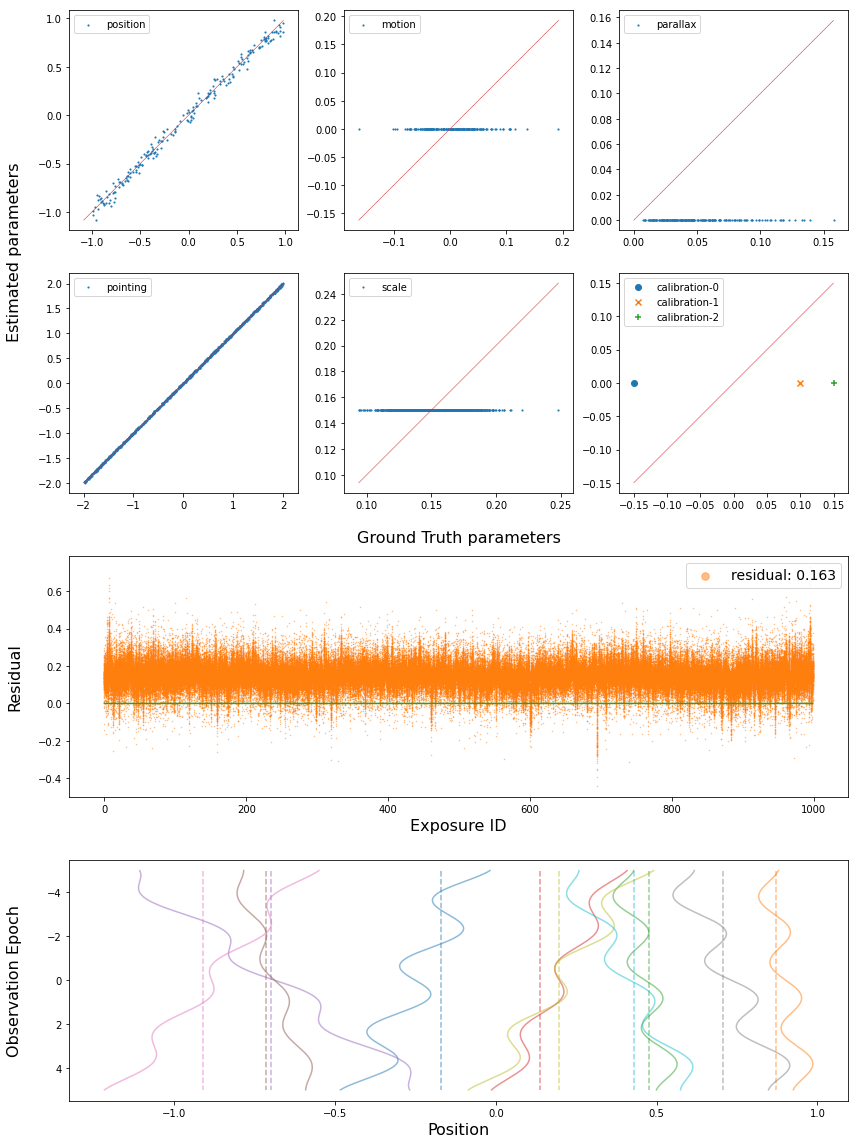

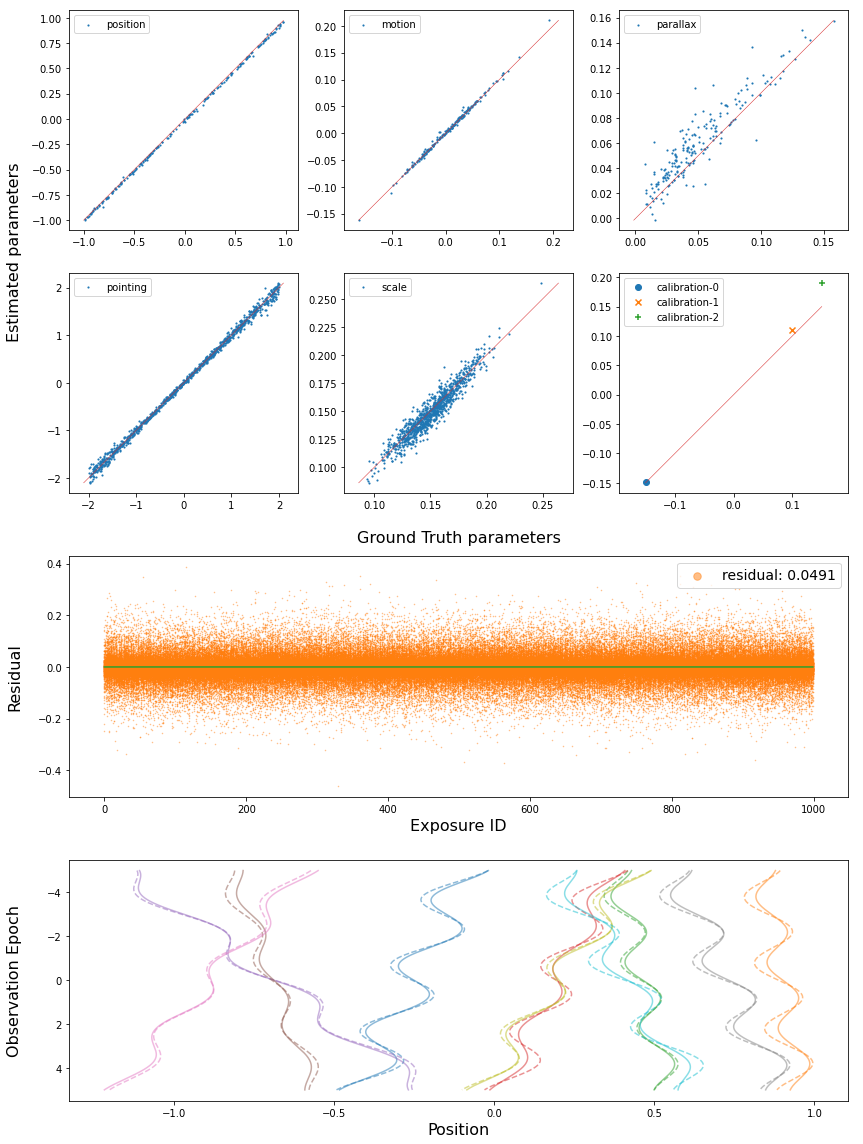

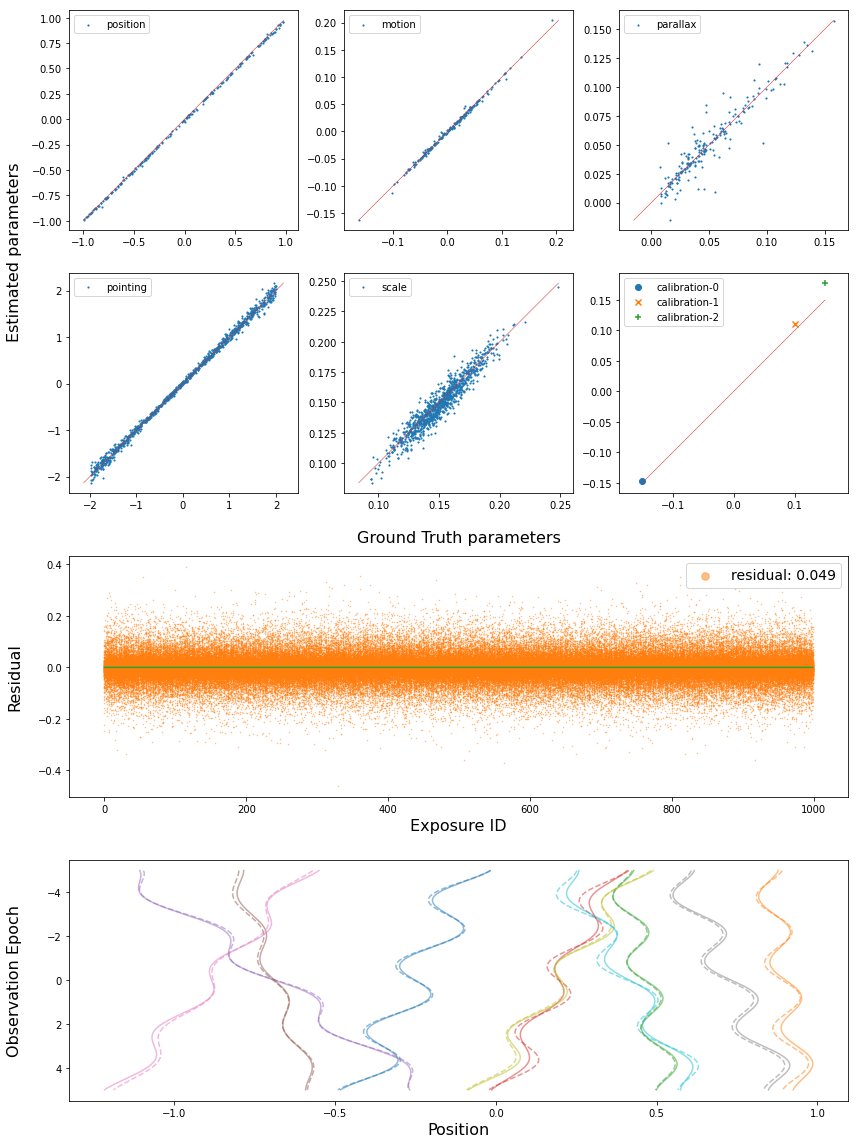

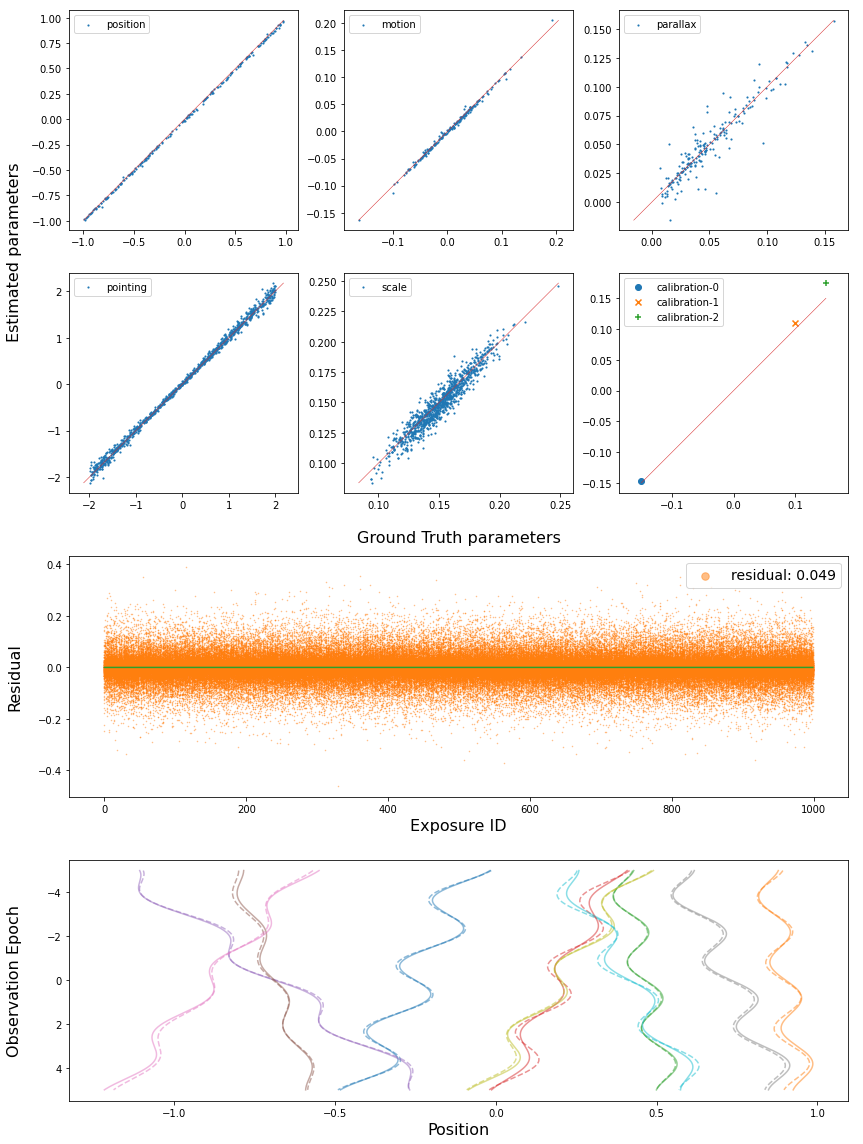

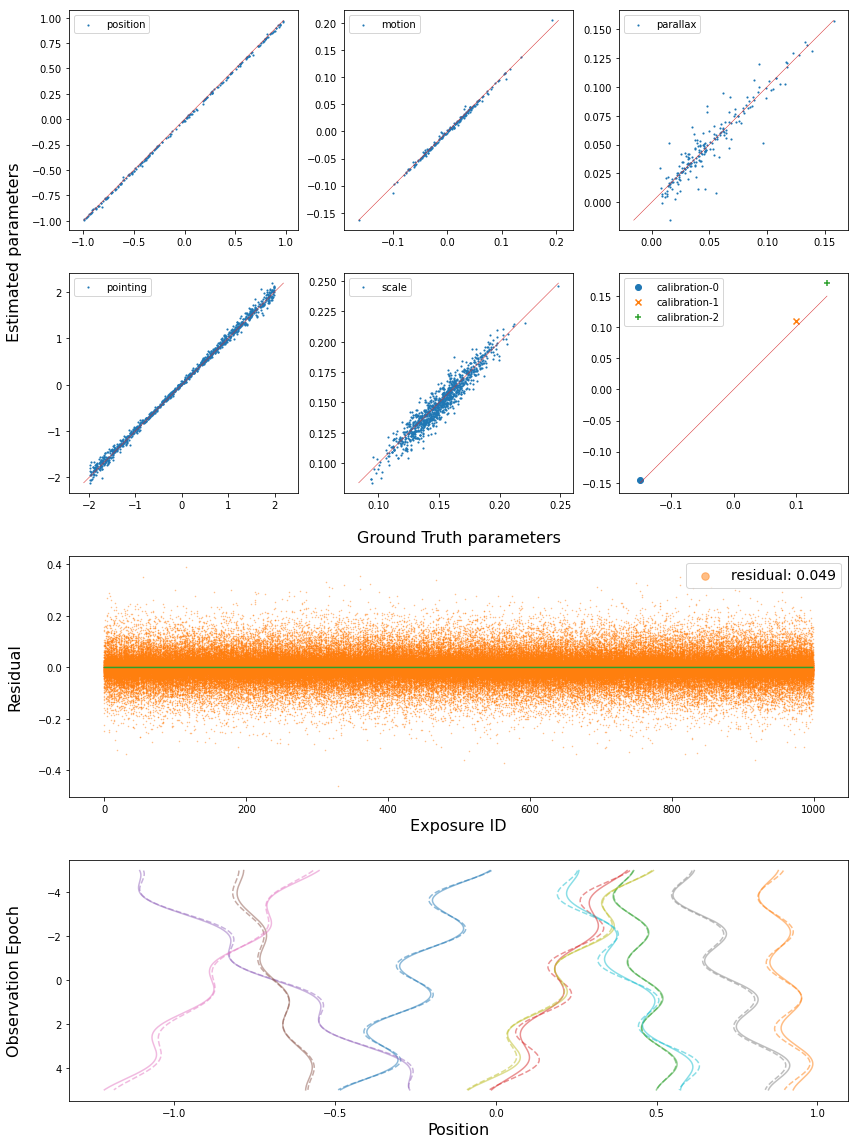

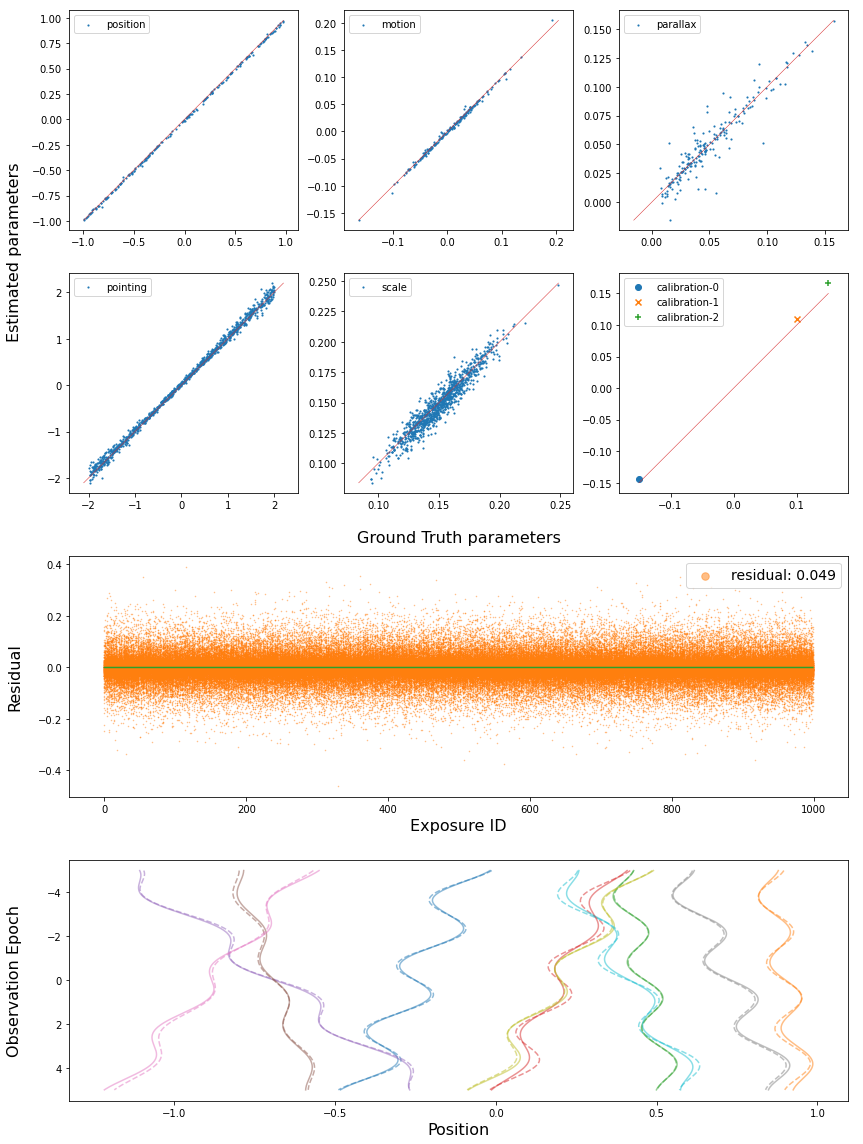

In [17]:
sx = shat
ex = ehat
cx = chat
fig = visualize(sx, ex, cx)
fig.savefig('agistoy_initial.pdf')

for n in range(5):
  cx = update_calibration(obs, ref, sx, ex, cx)
  sx = update_source(obs, ref, sx, ex, cx)
  ex = update_exposure(obs, ref, sx, ex, cx)
  fig = visualize(sx, ex, cx)
  fig.savefig(f'agistoy_cse_update_{n+1:02d}.pdf')

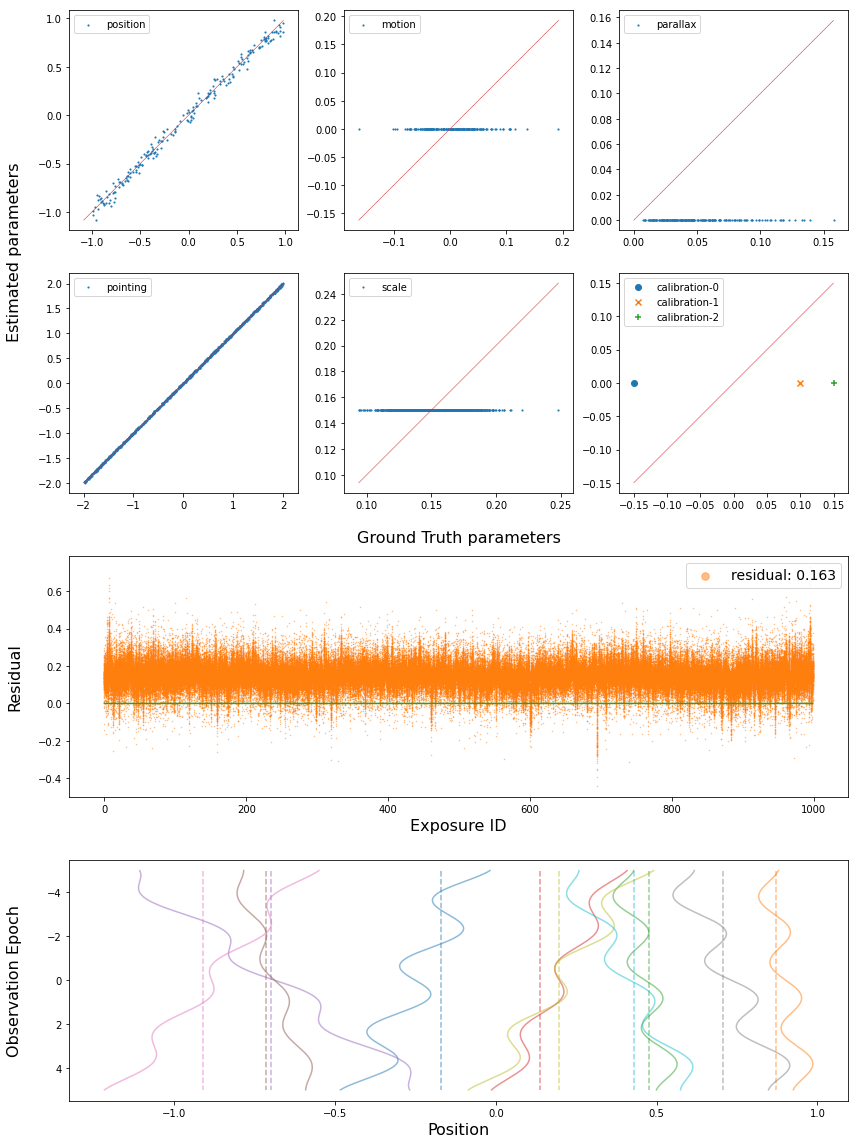

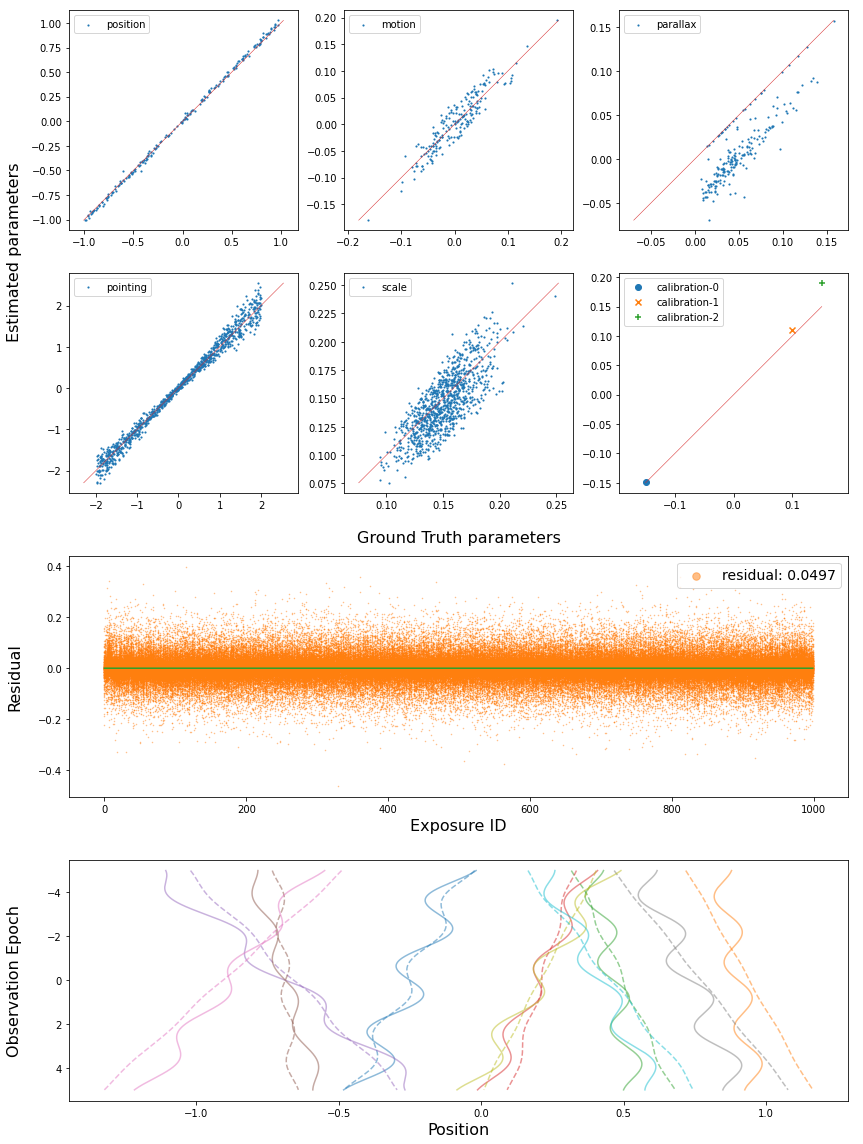

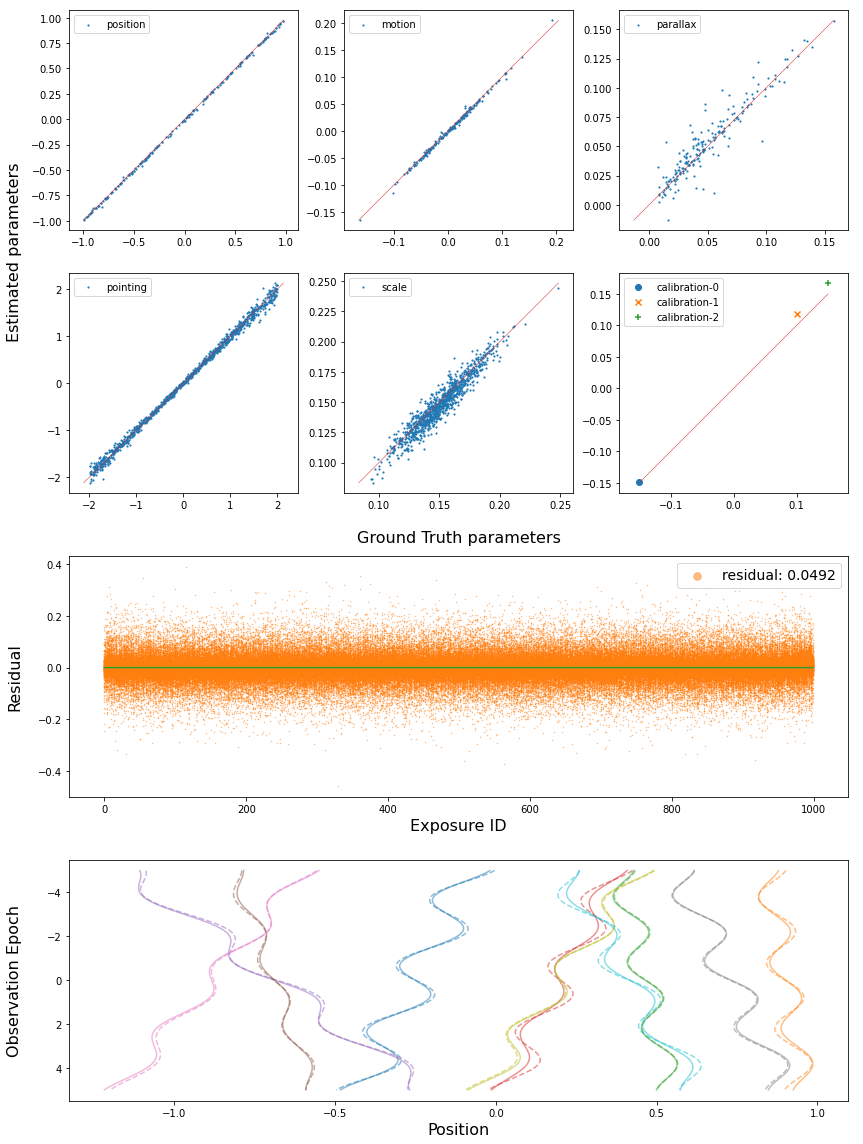

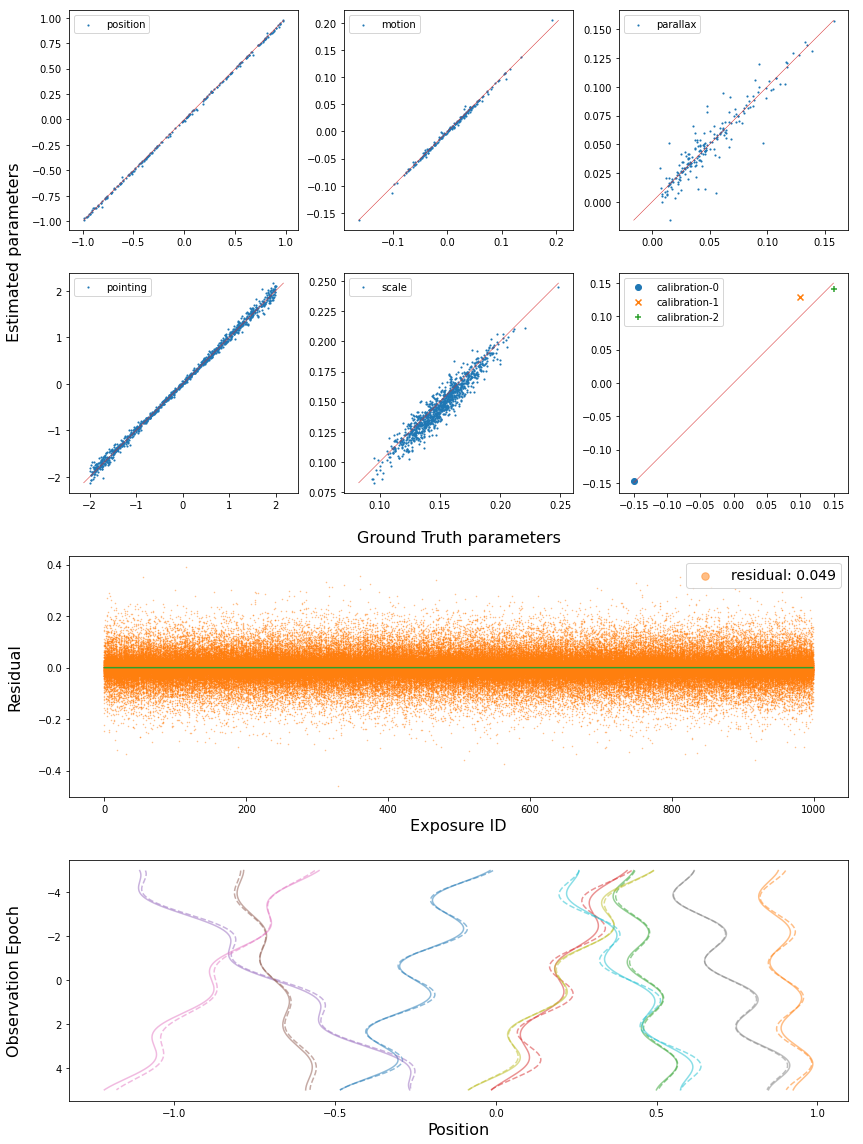

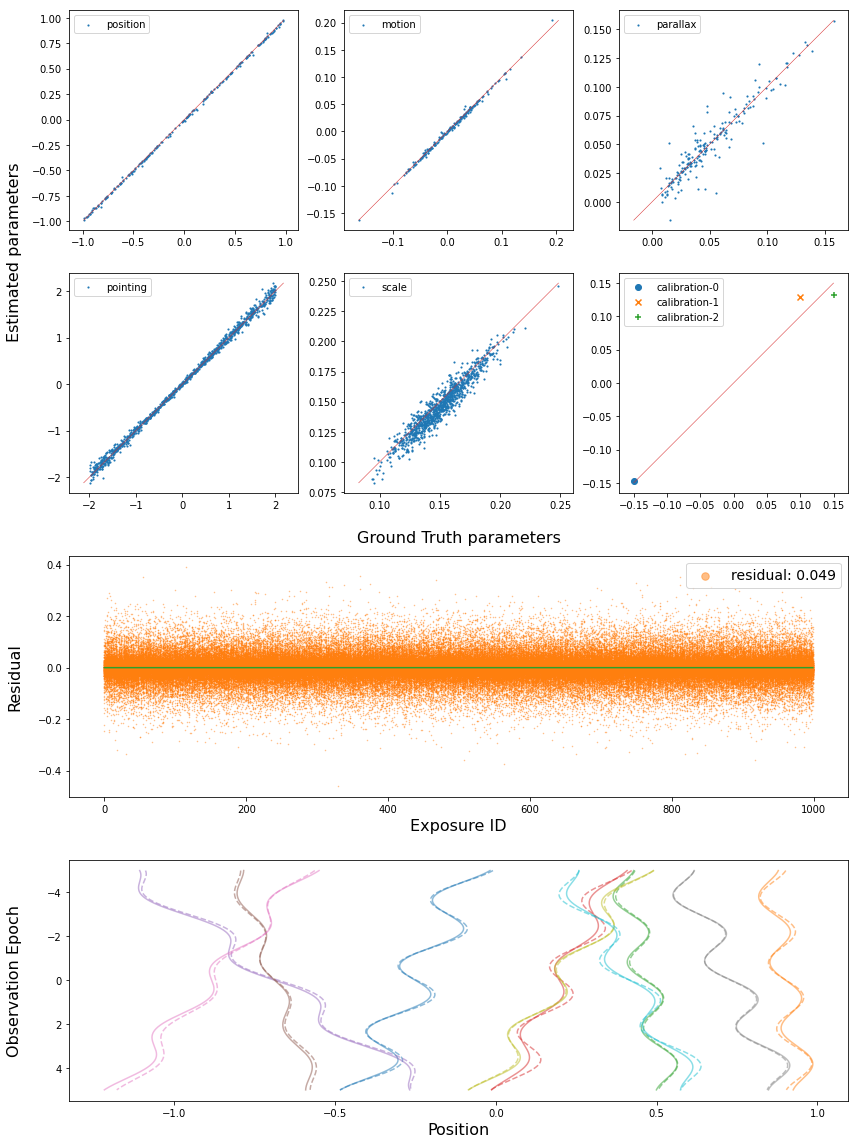

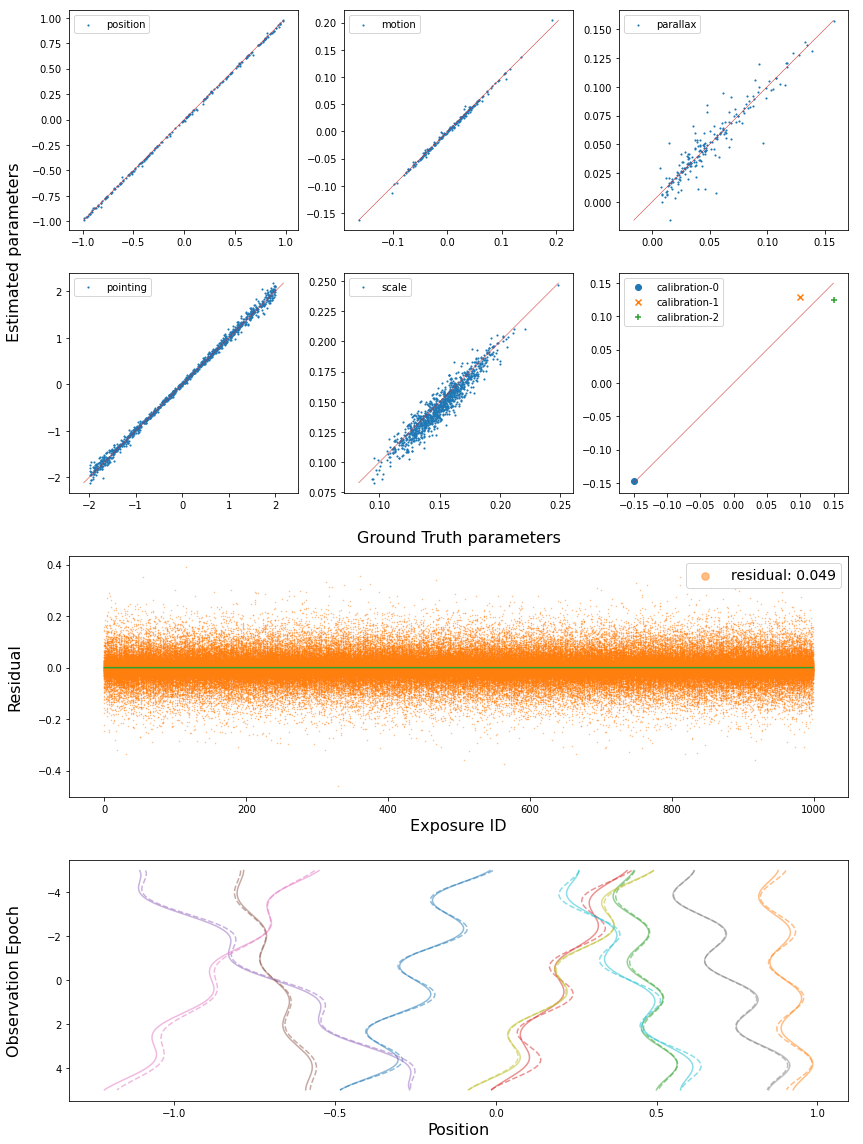

In [18]:
sx = shat
ex = ehat
cx = chat
fig = visualize(sx, ex, cx)

for n in range(5):
  cx = update_calibration(obs, ref, sx, ex, cx)
  ex = update_exposure(obs, ref, sx, ex, cx)
  sx = update_source(obs, ref, sx, ex, cx)
  fig = visualize(sx, ex, cx)
  fig.savefig(f'agistoy_ces_update_{n+1:02d}.pdf')